In [ ]:
# === colab configuration ===
# Skip this cell if running demo file locally!

from google.colab import drive
import sys

# setting paths
repository_path = '/content/time-series-forecasting-with-transformers/'
dataset_path = repository_path + 'datasets/spx.csv'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
# drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/francescobaraldi/time-series-forecasting-with-transformers
# ! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'main'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from tqdm import tqdm

from dataset import StockDatasetSW_multistep, StockDatasetSW_singlestep
from model import Transformer, TransformerDecoder, TransformerDecoder_v2, DotProductAttention
from eval_plot import eval_mae, eval_mae_decoder, plot_scores
from utils import scaler

try:
    executing_on_colab
except NameError:
    executing_on_colab = False

In [ ]:
# Testing on attention operator
d = 1
model = DotProductAttention()
queries = torch.rand((32, 7, d))
keys = torch.rand((32, 7, d))
values = torch.rand((32, 7, 1024))
out = model(queries, keys, values)

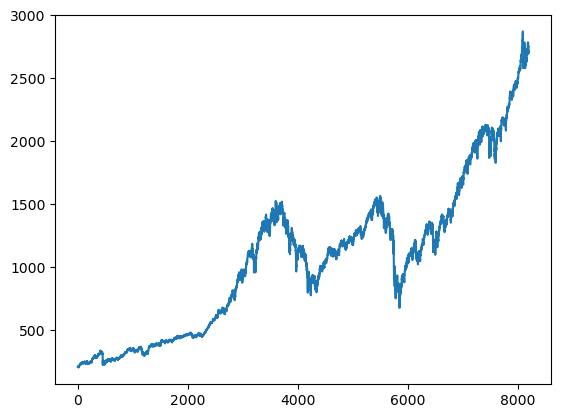

In [2]:
if not executing_on_colab:
    dataset_path = "datasets/spx.csv"
sp500 = pd.read_csv(dataset_path)
sp500.head()
plt.plot(sp500['close'])
plt.show()

In [ ]:
dates = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in sp500['Date']]
dates = mdates.drange(dates[0], dates[-1], datetime.timedelta(days=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.plot(dates, sp500['Close'])
plt.gcf().autofmt_xdate()
plt.show()

In [10]:
data = sp500['close'].to_numpy()
data = torch.from_numpy(data).to(torch.float32)

trainset = data[0:int(len(data) * 0.7)]
testset = data[int(len(data) * 0.7):]

trainset_scaled, testset_scaled = scaler(trainset, testset)

## Transformer std.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
learning_rate = 0.01
epochs = 10
window_len = 7
output_len = 3
train_dataset = StockDatasetSW_multistep(trainset_scaled, window_len, output_len)
test_dataset = StockDatasetSW_multistep(testset_scaled, window_len, output_len)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
model = Transformer(seq_len=window_len, num_encoder=6, num_decoder=6, input_size=1, output_size=output_len, d_model=512, num_heads=8, feedforward_dim=1024).to(device)
loss_fun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_maes = []
test_maes = []
for e in tqdm(range(epochs)):
    model.eval()
    train_mae = eval_mae(model, train_dl, device)
    test_mae = eval_mae(model, test_dl, device)
    train_maes.append(train_mae.cpu())
    test_maes.append(test_mae.cpu())
    print(f"Epoch {e} - Train MAE {train_mae} - Test MAE {test_mae}")
    model.train()
    for i, (src, trg, trg_y) in enumerate(train_dl):
        src, trg, trg_y = src.to(device), trg.to(device), trg_y.to(device)
        optimizer.zero_grad()
        out = model(src, trg)
        loss = loss_fun(out, trg_y)
        if i % 50 == 0:
            print(f'loss {loss.cpu().item():.3f}')
        loss.backward()
        optimizer.step()
plot_scores(train_maes, test_maes)

## Transformer decoder

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
learning_rate = 0.01
epochs = 10
window_len = 7
train_dataset = StockDatasetSW_singlestep(trainset, window_len)
test_dataset = StockDatasetSW_singlestep(testset, window_len)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
model = TransformerDecoder(seq_len=window_len, num_layer=1, input_size=1, d_model=1, num_heads=1, feedforward_dim=32).to(device)
loss_fun = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_maes = []
test_maes = []
losses = []
for e in tqdm(range(epochs)):
    model.eval()
    train_mae = eval_mae_decoder(model, train_dl, device)
    test_mae = eval_mae_decoder(model, test_dl, device)
    train_maes.append(train_mae.cpu())
    test_maes.append(test_mae.cpu())
    print(f"Epoch {e} - Train MAE {train_mae} - Test MAE {test_mae}")
    model.train()
    avg_loss = 0
    count = 0
    for i, (src, trg) in enumerate(train_dl):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        out = model(src)
        loss = loss_fun(out, trg)
        avg_loss += loss.cpu().detach().numpy().item()
        if i % 50 == 0:
            print(f'loss {loss.cpu().item():.3f}')
        loss.backward()
        optimizer.step()
        count += 1
    avg_loss /= count
    losses.append(avg_loss)
plot_scores(train_maes, test_maes, losses)